# Récupération du dataset
## Téléchargement
Si la commande gdown n'est pas reconnu, il faut l'installer :
__pip install gdown__ Dataset

In [1]:
!gdown --id 1sQEIPh3bdKQ_1J3g0Z8CRqD6uU7v746l

Downloading...
From: https://drive.google.com/uc?id=1sQEIPh3bdKQ_1J3g0Z8CRqD6uU7v746l
To: /home/v/Documents/Dev/PythonProjects/Notebooks/dataset.zip
100%|████████████████████████████████████████| 236M/236M [00:36<00:00, 6.43MB/s]


## Décompression

In [2]:
!unzip dataset.zip -u

Archive:  dataset.zip
caution: filename not matched:  -u


## Vérification

In [1]:
# Librairie permettant de représenter le système de fichiers sous forme d'objet
import pathlib

# Construction d'un objet associé au dossier flowers dans le répertoire courant
data_dir = pathlib.Path("./flowers")

# Vérifie si le chemin existe
if data_dir.exists():
    # Compte le nombre d'image qu'il y a dans les sous dossiers de flowers
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Il y a", image_count, "images dans les sous-dossiers")

Il y a 4317 images dans les sous-dossiers


# Construction du dataset

In [2]:
from PIL import Image
# Librarie numpy
import numpy as np
# Librairie permettant d'utiliser des fonctions dépendantes du sytème d'exploitation
import os

# Construction d'un objet associé au dossier flowers dans le répertoire courant
data_dir = pathlib.Path("./flowers")

# Initialisation du dataset
dataset = []

# Vérifie si le chemin existe
if data_dir.exists():
    # Compte le nombre d'image qu'il y a dans les sous dossiers de flowers
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Il y a", image_count, "images dans les sous-dossiers")
    
    # Initialisation du compte des images utilisées dans le dataset
    count = 0
    
    print("Construction du dataset..")
    # Pour chaque sous-dossier dans flowers
    for label in os.listdir("./flowers/"):
        # Pour chaque fichier dans le sous-dossier
        for filename in os.listdir(os.path.join("./flowers/",label)):
            # Incrémente le nombre d'image utilisées dans le dataset
            count = count + 1
            # Indique que l'on lit l'image <filename>
            # print(str(count) + " ---loading " + filename)
            # Lecture de l'image
            image = Image.open(os.path.join("./flowers/",label,filename))
            image.load()
            image = np.asarray(image, dtype="float32" )
            # Ajout au dataset de l'image associée à son dossier
            dataset.append((image, label))
    print("dataset créé.")

Il y a 4317 images dans les sous-dossiers
Construction du dataset..
dataset créé.


## Mélange le dataset

In [3]:
# Librairie permettant notamment de générer des nombres aléatoires
import random
# Affiche 10 échantillons du dataset tirés au hasard
# print(random.sample(dataset, 10))

# Mélange aléatoirement le dataset
random.shuffle(dataset)

## Affichage de 9 éléments du dataset

Affiche les 9 premières images du dataset


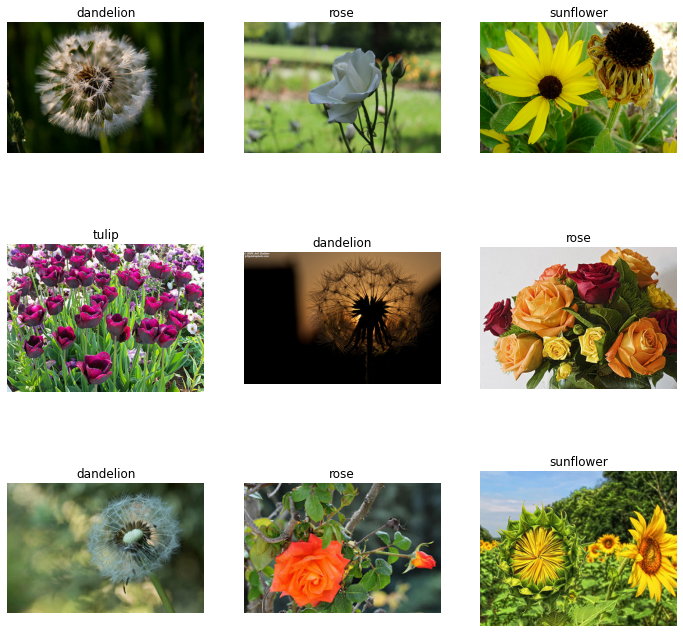

In [4]:
# Librairie permettant notamment d'afficher proprement des images, graphiques, etc..
import matplotlib.pyplot as plt

# Renvoie un objet Figure, fig, et un tableau d'Axes
# fig correspond au conteneur de tous les éléments
# axs correspond à un tableau représentant les sous-parties de la figure
# Ici la Figure sera divisé en 9 cases (9 Axes)
fig, axs = plt.subplots(3, 3, figsize = (12, 12))

# Modifie le mappage des couleurs des plots en gris
plt.gray()

# Description de dataset
#   dataset[i] = (matrice, dossier)
#   dataset[i][0] = matrice
#   dataset[i][1] = dossier
#   dataset[i][0][j] = ligne j de la matrice
#   dataset[i][0][j][k] = pixel aux coordonnées [j;k] de la matrice
for i, ax in enumerate(axs.flat):
    # Place dans Axe dans la matrice de l'image i
    ax.imshow(dataset[i][0].astype("int32"))
    # Désactive les axes
    ax.axis('off')
    # Ajoute un titre, celui du dossier auquel appartient l'image
    ax.set_title(dataset[i][1])

print("Affiche les 9 premières images du dataset")
plt.show()

# Construction du modèle
## Pré-traitement
### Redimensionnement

In [5]:
# Définition d'une taille pour redimensionner les images du dataset
image_size = (32, 32)

In [6]:
# Librarie OpenCV
import cv2
# Initialisation du tableau des images redimensionnées
resized = []

# Redimensionne les images du dataset et insères ces dernières dans le tableau resized
for d in dataset:
    resized.append((cv2.resize(d[0], image_size), d[1]))

In [7]:
# On considère maintenant le dataset comme étant les images redimensionnées
dataset = resized

### Transformation en feature

In [8]:
# Création d'un tableau images qui contient seulement les images du dataset
images = np.asarray([d[0] for d in dataset])
# Vérifie la forme du tableau (nbCases1D, nbCases2D, ..., nbCasesND)
print(images.shape)

(4317, 32, 32, 3)


In [9]:
# Modifie la forme du tableau pour les images soient "applaties"/transformées en un tableau 1D
images = images.reshape(len(images), -1)
# Vérifie la forme du tableau après modification (nbCases1D, nbCases2D, ..., nbCasesND)
print(images.shape)

(4317, 3072)


### Normalisation

In [10]:
# Réencodage des valeurs de chaque image en float32 et "normalisation" des valeurs entre 0 et 255
images = images.astype(np.float32)

## Classification K-Means

In [91]:
# Import d'un objet utilisé comme modèle de classification k-means
from sklearn.cluster import MiniBatchKMeans

# Indique le nombre de classes à classifier (ici niombre d'espèces de fleurs)
nb_flowers = 5

# Définition d'un modèle K-Means
kmeans = MiniBatchKMeans(n_clusters=nb_flowers)

# Entraînement du modèle
kmeans.fit(images)

MiniBatchKMeans(n_clusters=5)

In [92]:
print(kmeans.labels_)
print(kmeans.n_clusters)

[1 4 2 ... 1 1 4]
5


### Association entre clusters et classes

In [93]:
def map_clusters_classes(kmeans, classes):
    print("Mapping..")
    mapping = {}
    classes_unique = np.unique(classes)
    print("n_clusters :", kmeans.n_clusters)
    print("different classes : ", classes_unique)
    for i in range(kmeans.n_clusters):
        print("i=", i, " labels[i]=", classes_unique[i])
        mapping[i] = classes_unique[i]
    return mapping

def inference(kmeans, images, classes):
    print("Inference..")
    
    mapping = map_clusters_classes(kmeans, classes)
    print("mapping : ", mapping)
    
    # Renvoie les labels auquels sont associés chaque images du dataset
    clusters = kmeans.predict(images)
    print("clusters : ", clusters)
    
    # Définition des prédictions
    predicted_classes = np.zeros(len(clusters)).astype(np.uint8)
    
    for n_cluster in range(len(clusters)):
        predicted_classes[n_cluster] = mapping[clusters[n_cluster]]
    
    print("predictions : ", predicted_classes)
    return predicted_classes

In [94]:
# Définition d'un dictionnaire permettant d'associer une espèce de fleur à un nombre
labels_classes_mapping = {"daisy":0,"dandelion":1,"rose":2,"sunflower":3,"tulip":4}

# Définition d'un tableau classes contenant les espèces associées aux images du dataset
classes = [labels_classes_mapping[d[1]] for d in dataset]

# Transformation du tableau en un numpy array
classes = np.asarray(classes)

predicted_classes = inference(kmeans, images, classes)


#print(predicted_classes[:20])
#print(classes[:20])

Inference..
Mapping..
n_clusters : 5
diffrent classes :  [0 1 2 3 4]
i= 0  labels[i]= 0
i= 1  labels[i]= 1
i= 2  labels[i]= 2
i= 3  labels[i]= 3
i= 4  labels[i]= 4
mapping :  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
clusters :  [1 4 2 ... 1 1 4]
predictions :  [1 4 2 ... 1 1 4]


## Evaluation

In [95]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(classes, predicted_classes)
print('Accuracy: {}\n'.format(acc))

Accuracy: 0.23673847579337504



In [97]:
number_clusters = [5, 10, 16, 36, 64, 144, 256, 1024, 2048, 4098]
acc_list = []

for n_clusters in number_clusters:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters)
    kmeans.fit(images)
    predicted_classes = inference(kmeans, images, classes)
    acc = accuracy_score(classes, predicted_labels)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))


Inference..
Mapping..
n_clusters : 5
diffrent classes :  [0 1 2 3 4]
i= 0  labels[i]= 0
i= 1  labels[i]= 1
i= 2  labels[i]= 2
i= 3  labels[i]= 3
i= 4  labels[i]= 4
mapping :  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
clusters :  [0 1 2 ... 0 0 1]
predictions :  [0 1 2 ... 0 0 1]
Accuracy: 0.2038452629140607

Inference..
Mapping..
n_clusters : 10
diffrent classes :  [0 1 2 3 4]
i= 0  labels[i]= 0
i= 1  labels[i]= 1
i= 2  labels[i]= 2
i= 3  labels[i]= 3
i= 4  labels[i]= 4


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(number_clusters, acc_list, label='accuracy', marker='^')
ax.legend(loc='best')
ax.grid('on')
ax.set_title('Accuracy per each cluster number')
plt.show()